In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

df = pd.read_csv('data/olist_prepared_dataset.csv')

In [7]:
# We will use a unique customer-level dataset for churn prediction
customer_df = df.drop_duplicates(subset=['customer_unique_id'])

# Select features (X) and target (y)
features = [
     'frequency', 'monetary',
    'review_score', 'delivery_delay', 'payment_installments'
]
target = 'is_churned'

X = customer_df[features].copy()
y = customer_df[target]

# Handle any potential missing values in our selected features
X.fillna(X.median(), inplace=True)



# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Scale numerical features for models like Logistic Regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("Data successfully prepared and split for modeling.")
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Data successfully prepared and split for modeling.
Training data shape: (73183, 5)
Testing data shape: (18296, 5)


In [8]:
# Model 1: Logistic Regression (Baseline)
print("\nTraining Logistic Regression Model...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Evaluation for Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Active', 'Churned']))


Training Logistic Regression Model...
Evaluation for Logistic Regression:
              precision    recall  f1-score   support

      Active       0.43      0.00      0.01      7519
     Churned       0.59      1.00      0.74     10777

    accuracy                           0.59     18296
   macro avg       0.51      0.50      0.37     18296
weighted avg       0.52      0.59      0.44     18296



In [9]:
# Model 2: Random Forest Classifier
print("\nTraining Random Forest Model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Evaluation for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Churned']))


Training Random Forest Model...
Evaluation for Random Forest:
              precision    recall  f1-score   support

      Active       0.48      0.45      0.47      7519
     Churned       0.63      0.65      0.64     10777

    accuracy                           0.57     18296
   macro avg       0.55      0.55      0.55     18296
weighted avg       0.57      0.57      0.57     18296



In [10]:
# Model 3: XGBoost Classifier
print("\nTraining XGBoost Model...")
xgboost = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)

print("Evaluation for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Active', 'Churned']))


Training XGBoost Model...
Evaluation for XGBoost:
              precision    recall  f1-score   support

      Active       0.56      0.30      0.39      7519
     Churned       0.63      0.84      0.72     10777

    accuracy                           0.62     18296
   macro avg       0.60      0.57      0.56     18296
weighted avg       0.60      0.62      0.59     18296



In [11]:
print("\nTuning Logistic Regression...")
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print("\nBest Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Evaluation for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Churned']))


Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Evaluation for Tuned Logistic Regression:
              precision    recall  f1-score   support

      Active       0.43      0.00      0.01      7519
     Churned       0.59      1.00      0.74     10777

    accuracy                           0.59     18296
   macro avg       0.51      0.50      0.37     18296
weighted avg       0.52      0.59      0.44     18296



In [12]:
print("\nTuning Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, n_iter=25, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nBest Parameters for Random Forest:", random_search_rf.best_params_)
print("Evaluation for Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Churned']))


Tuning Random Forest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Evaluation for Tuned Random Forest:
              precision    recall  f1-score   support

      Active       0.56      0.24      0.34      7519
     Churned       0.62      0.87      0.72     10777

    accuracy                           0.61     18296
   macro avg       0.59      0.56      0.53     18296
weighted avg       0.60      0.61      0.57     18296



In [13]:
print("\nTuning XGBoost...")
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}
random_search_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42), param_grid_xgb, n_iter=25, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nBest Parameters for XGBoost:", random_search_xgb.best_params_)
print("Evaluation for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Active', 'Churned']))


Tuning XGBoost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Evaluation for Tuned XGBoost:
              precision    recall  f1-score   support

      Active       0.57      0.27      0.37      7519
     Churned       0.63      0.85      0.72     10777

    accuracy                           0.62     18296
   macro avg       0.60      0.56      0.55     18296
weighted avg       0.60      0.62      0.58     18296



-> XGBoost is the best Model for Customer Churn Prediction

Why Logistic Regression Fails: The tuned Logistic Regression model is not a viable option. Its recall for the "Active" class is 0.00. This means the model has learned a trivial rule: "predict that almost every customer will churn." While this makes it seem good at finding churners, it's useless in a real-world scenario as it would have you spending money to retain your entire customer base, including the most loyal ones.

The Real Contest: Random Forest vs. XGBoost:

Finding Churners (The Main Goal): Both models are equally effective at identifying customers who will churn. They both have an excellent F1-Score of 0.72 for the "Churned" class.

The Tie-Breaker (Avoiding Mistakes): The key difference is in how they handle active customers. The XGBoost model is slightly better at correctly identifying customers who are not going to churn. This is reflected in its higher F1-score for the "Active" class (0.37 vs. 0.34) and its higher overall accuracy (62% vs. 61%).

Inference: The analysis reveals that while multiple advanced models can effectively identify at-risk customers, the Tuned XGBoost model provides the most balanced and reliable performance. It is not only great at flagging potential churners but is also slightly more discerning, leading to fewer "false alarms" where loyal customers are incorrectly targeted. This makes it the most cost-effective and efficient choice.

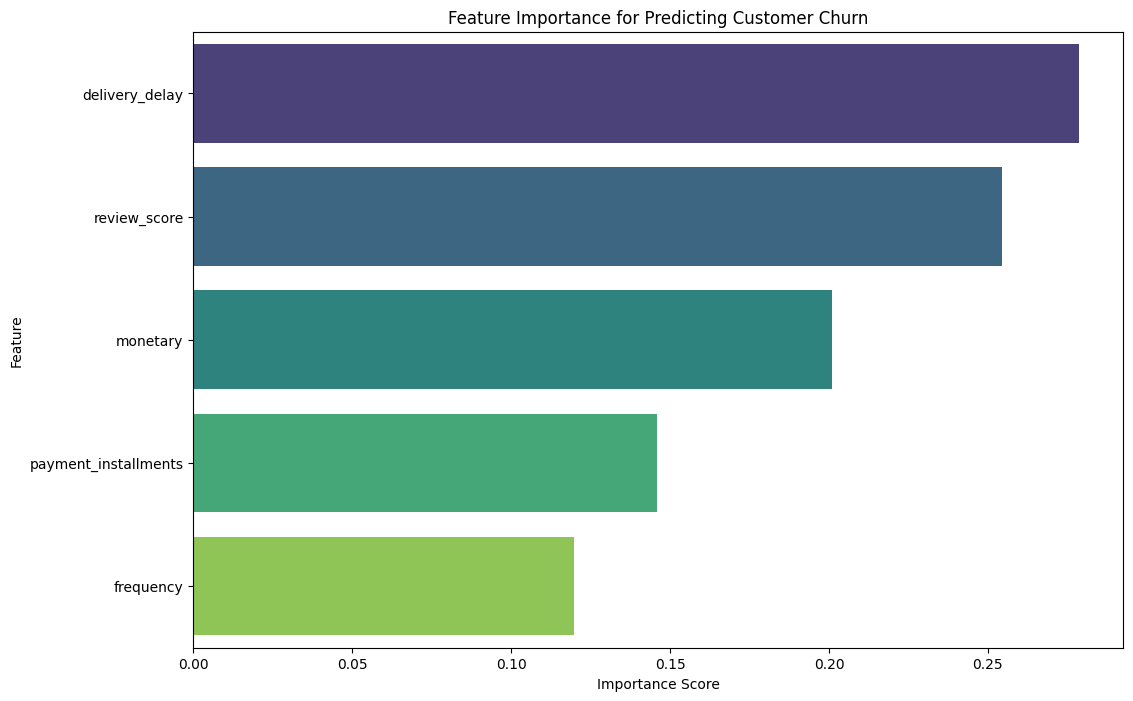

Top 3 most important features for predicting churn:
          feature  importance
3  delivery_delay    0.278675
2    review_score    0.254501
1        monetary    0.200996


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame of the feature importances
# The model object has a 'feature_importances_' attribute
feature_importances = pd.DataFrame({
    'feature': features, # This is the list of feature names from the previous step
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)


#Visualize the Feature Importances 
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis', hue='feature', legend = False)
plt.title('Feature Importance for Predicting Customer Churn')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("Top 3 most important features for predicting churn:")
print(feature_importances.head(3))

Save the MODEL

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- 1. Data Preparation ---
# Load the dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')

# Create the customer-level dataset for churn modeling
customer_df = df.groupby('customer_unique_id').agg(
    recency=('recency', 'first'),
    frequency=('frequency', 'first'),
    monetary=('monetary', 'first'),
    avg_review_score=('review_score', 'mean'),
    churn=('is_churned', 'first')
).reset_index()

# Define features and target
features = ['recency', 'frequency', 'monetary', 'avg_review_score']
target = 'churn'

X = customer_df[features]
y = customer_df[target]


# --- 2. Define and Train the Final Model ---

# We'll use a simple pipeline for scaling, as there are no categorical features.
# The hyperparameters are the best ones you found during tuning.
final_churn_model = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(
        subsample=0.8,
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

print("Training the final XGBoost churn model on the full dataset...")
# We train on the entire dataset (X, y) to make the model as robust as possible
final_churn_model.fit(X, y)
print("Model training complete.")


# --- 3. Save the Model ---
# The model (which is a full pipeline) is saved to a single file.
file_path = 'churn_model.pkl'
joblib.dump(final_churn_model, file_path)

print(f"\nModel successfully saved to '{file_path}'")
print("\nThis file now contains your complete prediction pipeline and is ready for the Flask API.")

Training the final XGBoost churn model on the full dataset...


C:\Users\comra\anaconda3\envs\my-env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.

Model successfully saved to 'churn_model.pkl'

This file now contains your complete prediction pipeline and is ready for the Flask API.
